## Analisis de Datos Exploratorio de los datos de texto

In [12]:
import os, glob, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ['retina']

In [13]:
from src import data
df = data.load('train').astype({'a_label': str})

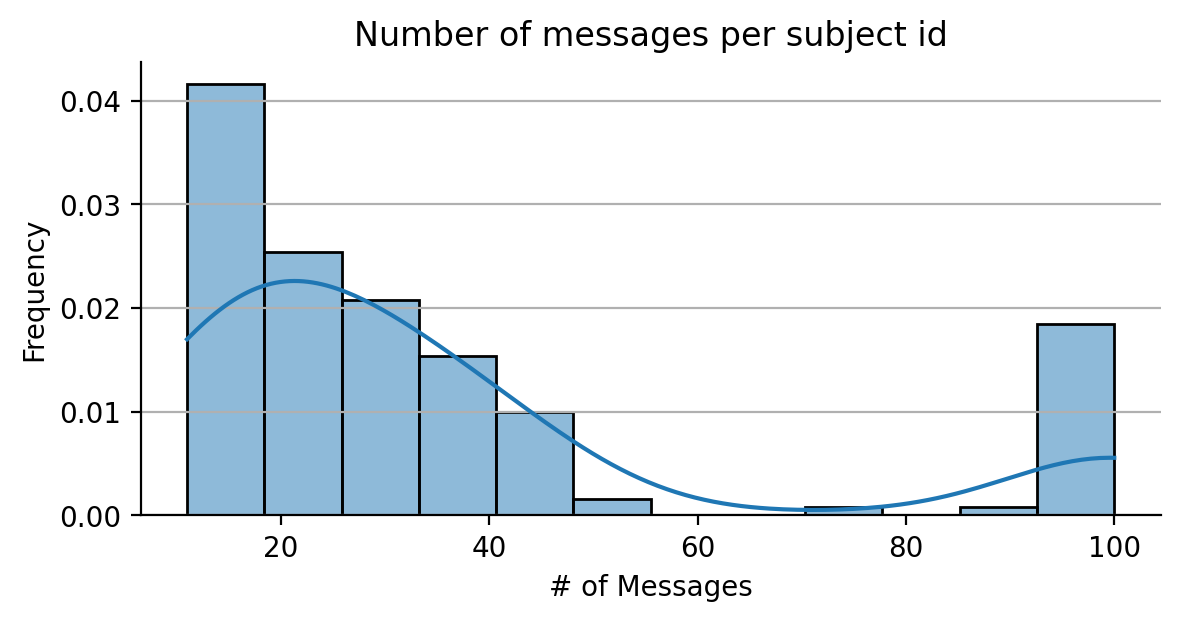

In [14]:
# Plot the histogram of the number of messages per subject
ax =sns.displot(df.groupby('subject_id').count()['id_message'], kde=True, stat='density', aspect=2, height=3)
ax.set(title='Number of messages per subject id', xlabel='# of Messages', ylabel='Frequency')
# plt.grid()
plt.grid(axis='y')
plt.show()
# ax = sns.displot(trial_df.groupby('subject_id').count()['id_message'], kde=True, stat='density', aspect=2, height=3)
# ax.set(title='Trial: Number of messages per subject id', xlabel='# of Messages', ylabel='Frequency')
# plt.show()

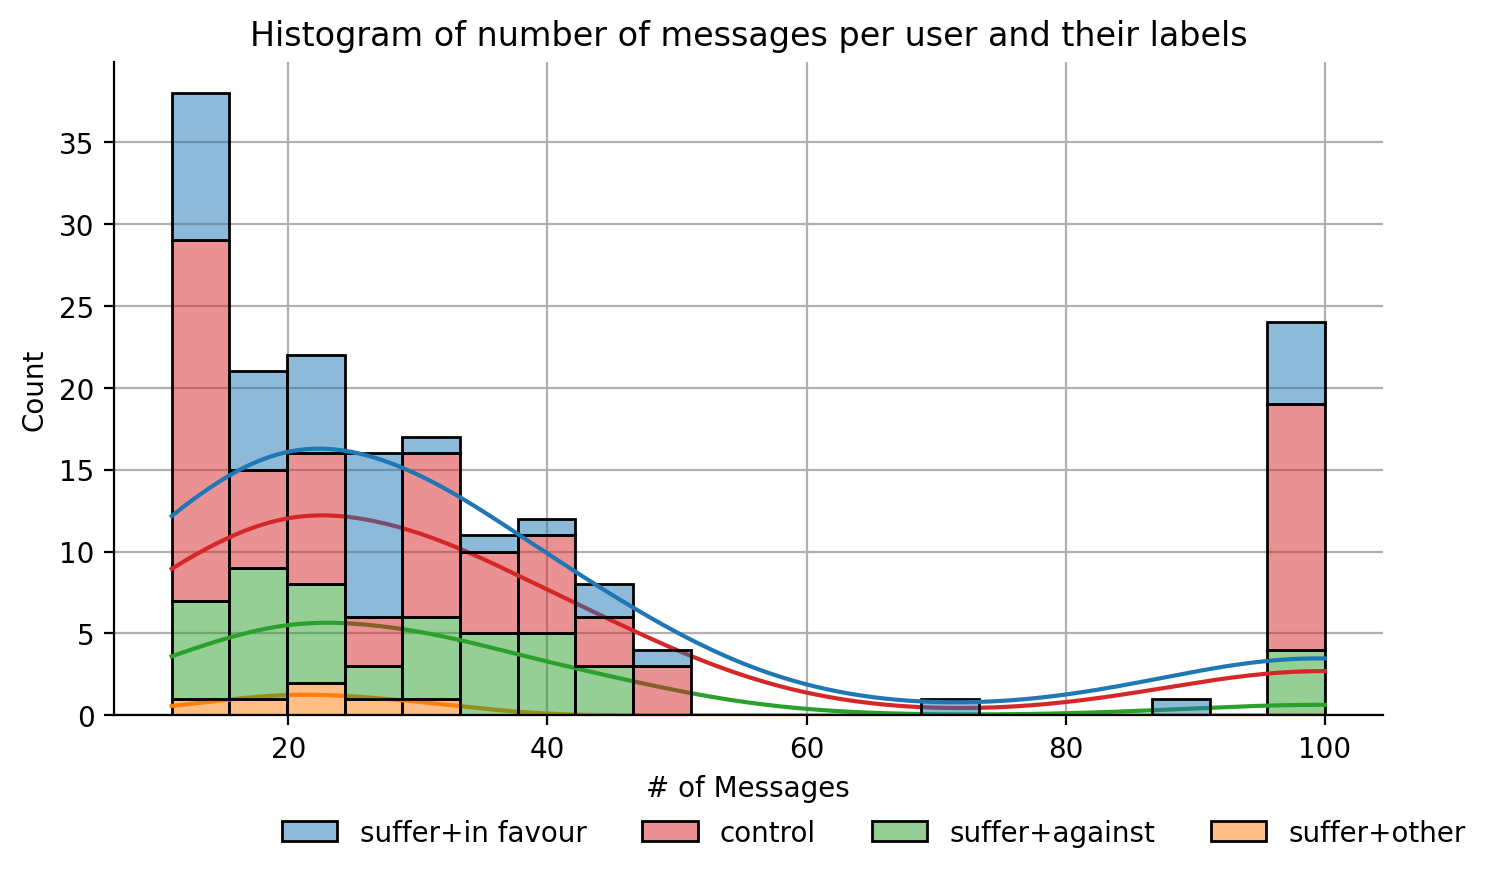

In [15]:
# Plot the histogram of the number of messages per subject stacking the labels
df_grouped = (
    df.groupby('subject_id')
    .agg({
        'id_message': 'count', 
        'message': lambda x: x.str.split(' ').str.len().sum(),
        **{col: 'first' for col in df.columns.drop(['subject_id', 'id_message', 'message'])}
    })
    .rename(columns={'id_message': 'n_messages', 'message': 'n_words'})
    .reset_index()
)
colors_dict = {
    'control': 'tab:red',
    'suffer+in favour': 'tab:blue',
    'suffer+against': 'tab:orange',
    'suffer+other': 'tab:green',
}
colors = df_grouped['c_label'].map(colors_dict)
# make palette
palette = sns.color_palette(['tab:blue', 'tab:red', 'tab:green', 'tab:orange'])
ax =sns.displot(
    df_grouped,
    x='n_messages',
    hue='c_label',
    palette=palette,
    multiple='stack',
    kde=True,
    # stat='density',
    aspect=1.8,
    height=4,
    legend=True,
    zorder=2,
    bins=20,
)
sns.move_legend(ax, "lower center", ncol=4, bbox_to_anchor=(0.5, -0.05), frameon=False)
# remove legend title
ax._legend.set_title('')
    
ax.set(title='Histogram of number of messages per user and their labels', xlabel='# of Messages', ylabel='Count')

plt.grid()
plt.show()
# ax = sns.displot(trial_df.groupby('subject_id').count()['id_message'], kde=True, stat='density', aspect=2, height=3)
# ax.set(title='Trial: Number of messages per subject id', xlabel='# of Messages', ylabel='Frequency')
# plt.show()

/var/folders/jj/p12jwj113hv_73vsjrcjcw040000gn/T/ipykernel_48000/4069306773.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='center')


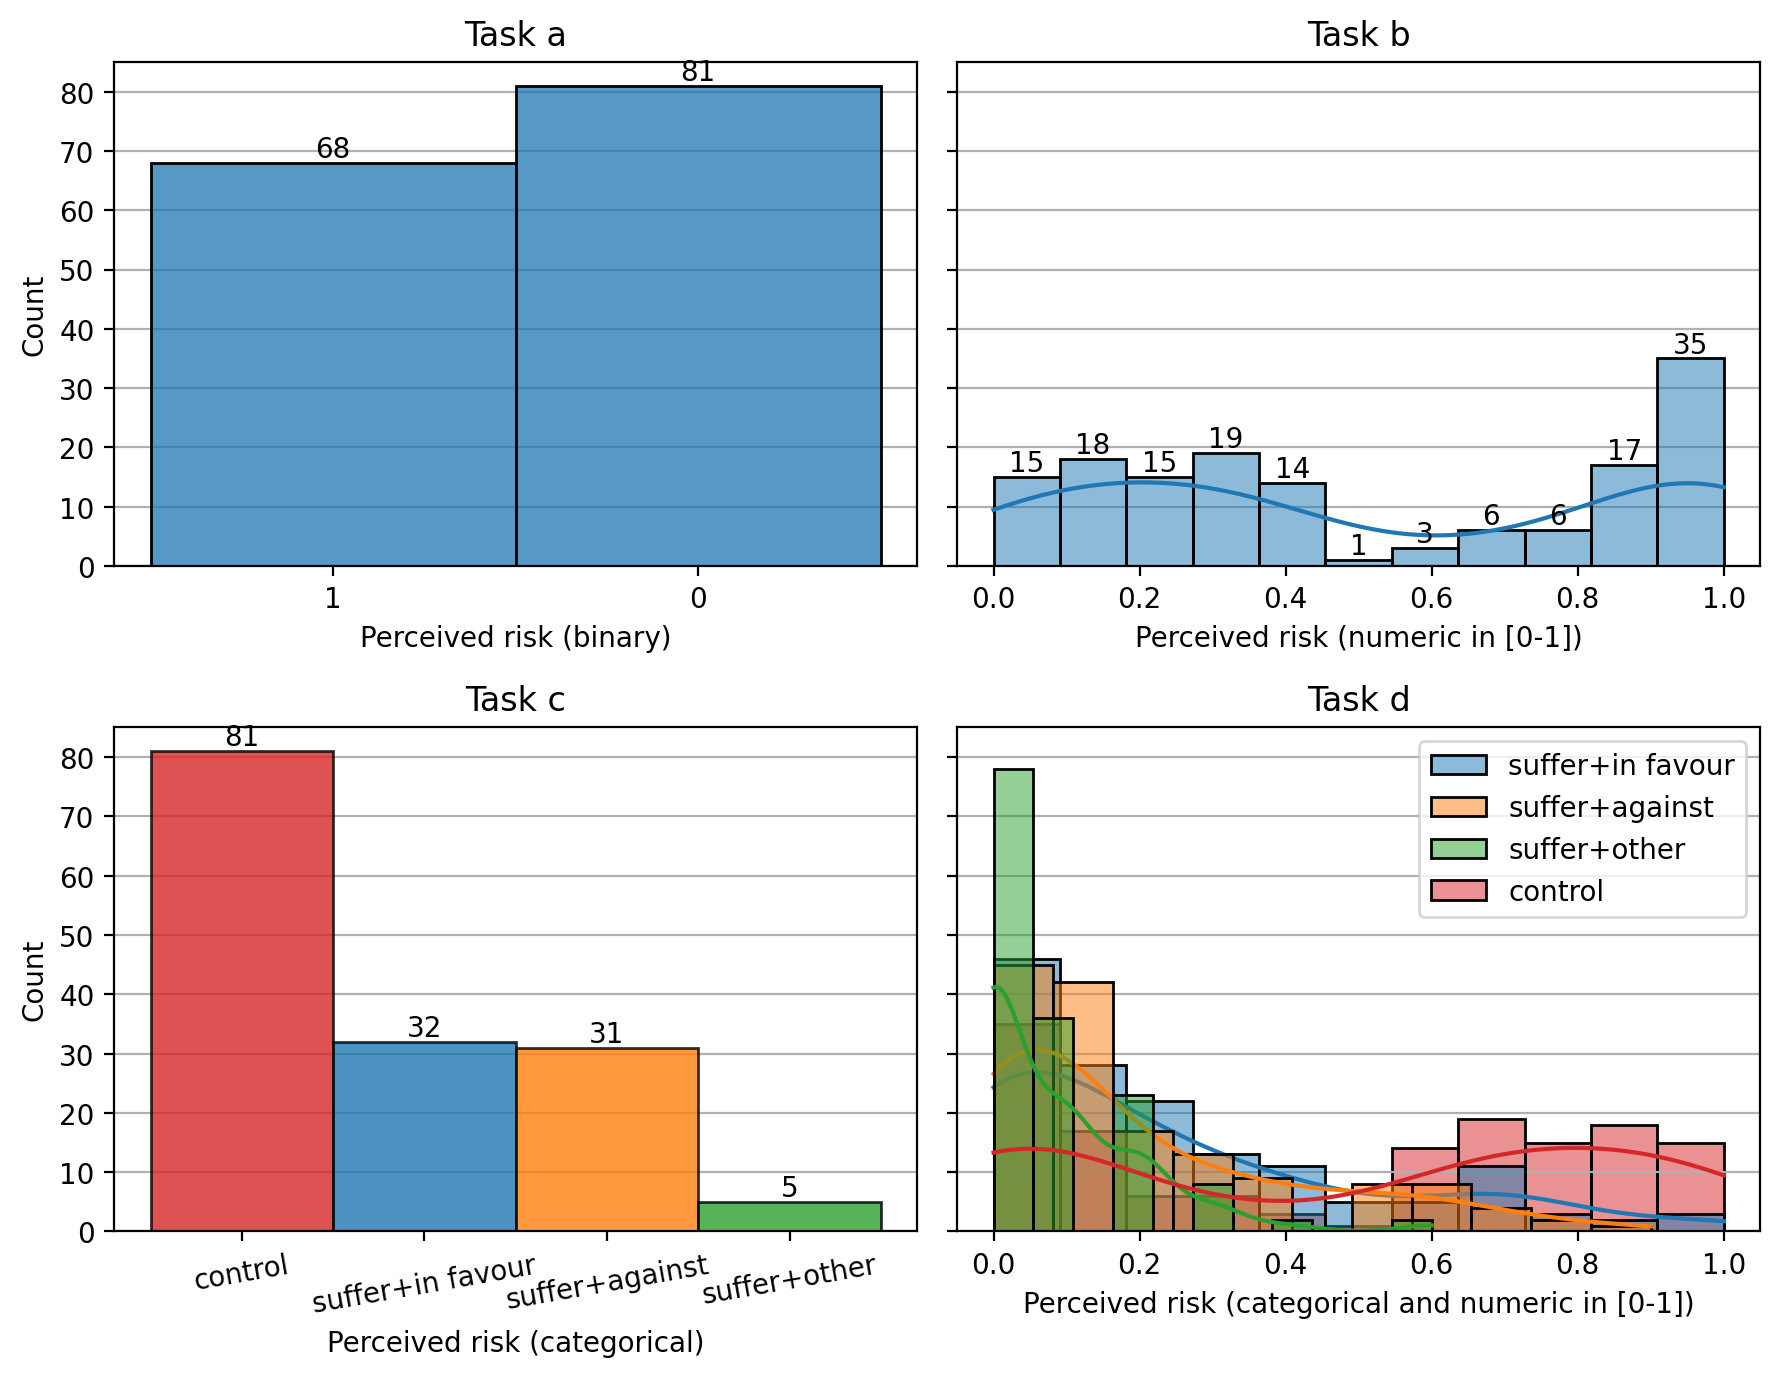

In [67]:
# plot the distributions of each task label
colors_dict = {
    'control': 'tab:red',
    'suffer+in favour': 'tab:blue',
    'suffer+against': 'tab:orange',
    'suffer+other': 'tab:green',
}
task_xlabel = {
    'a': 'Perceived risk (binary)',
    'b': 'Perceived risk (numeric in [0-1])',
    'c': 'Perceived risk (categorical)',
    'd': 'Perceived risk (categorical and numeric in [0-1])'
}
df_grouped = df.groupby('subject_id').first()
df_grouped[f'c_label'] = pd.Categorical(df_grouped[f'c_label'], categories=colors_dict.keys())
df_grouped['a_label'] = df_grouped['a_label'].astype(str)
fig, axes = plt.subplots(2, 2, figsize=(9, 7), sharey=True)
for task, ax in zip(['a', 'b', 'c'], axes[:4].flatten()):
    # grid with only horizontal lines
    ax.grid(axis='y')
    # plot the histogram with 10 bins
    sns.histplot(df_grouped[f'{task}_label'], ax=ax, kde=(task=='b'), zorder=2, bins=11)
    ax.set(title=f'Task {task}', ylabel='Count', xlabel=task_xlabel[task])
    # orient the labels 10 degrees and center them
    if task=='c':
        ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha='center')
        # color the bars according to the label
        for bar, color in zip(ax.patches, colors_dict.values()):
            bar.set_color(color)
            bar.set_edgecolor('black')
            bar.set_alpha(0.8)
        # ax.legend(colors_dict.keys())
    # if task!='b':
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha = 'center', 
            va = 'center', 
            xytext = (0, 5), 
            textcoords = 'offset points'
        )
# plt.grid()
ax = axes[-1][-1]
ax.grid(axis='y')
sns.histplot(df_grouped[f'd_suffer_in_favour'], label='suffer+in favour', zorder=2, kde=True, ax=ax, bins=11)
sns.histplot(df_grouped[f'd_suffer_against'], label='suffer+against', zorder=2, kde=True, ax=ax, bins=11)
sns.histplot(df_grouped[f'd_suffer_other'], label='suffer+other', zorder=2, kde=True, ax=ax, bins=11)
sns.histplot(df_grouped[f'd_control'], label='control', zorder=1, kde=True, ax=ax, bins=11)
ax.set(xlabel=task_xlabel['d'], ylabel='Count', title='Task d')
plt.legend()
plt.tight_layout()
plt.show()


We can show that labels for the a,b, and c subtasks can be recovered from the ones of task 2d.

In [8]:
from src import data
import numpy as np
import pandas as pd
task_d_cols = ['suffer+in favour', 'suffer+against', 'suffer+other', 'control']

def make_task_labels_from_d(d_data:np.ndarray) -> pd.DataFrame:
    """
    Get the labels of all other tasks from the labels of the d task
    """
    if isinstance(d_data, pd.DataFrame):
        d_df = d_data.astype(float)
    else:
        d_df = pd.DataFrame(d_data, columns=task_d_cols).astype(float)
    df = d_df.assign(
        c_label = lambda df: df.iloc[:,:-1].apply(
            lambda x: df.columns[np.argmax(x)] if sum(x)>=0.5 else 'control', axis=1
        ),
        a_label=lambda df: (df.c_label!='control').astype(int),
        b_label = lambda df: df[task_d_cols[:-1]].sum(axis=1).round(2)
    )[['a_label', 'b_label', 'c_label']]
    return df

train_df = data.load('train')
display(train_df.head(2))
abc_labels_from_d_df = make_task_labels_from_d(train_df.filter(regex='^d_').values.astype(float))
display(abc_labels_from_d_df.head(2))

# check if the labels are correct
pd.testing.assert_frame_equal(
    abc_labels_from_d_df.reset_index(drop=True), 
    train_df[['a_label', 'b_label', 'c_label']]
        .astype({'a_label':int, 'b_label':float, 'c_label':str})
        .reset_index(drop=True)
)

,subject_id,round,id_message,date,message,d_suffer_in_favour,d_suffer_against,d_suffer_other,d_control,a_label,b_label,c_label
0,subject264,-1,18857139074,2020-10-16 07:04:25,Alguien que quiera charlar ?,0.3,0.4,0.3,0.0,1,1.0,suffer+against
1,subject264,-1,88125635023,2020-10-16 07:08:52,"Cualquier tema , dime uno ?",0.3,0.4,0.3,0.0,1,1.0,suffer+against


,a_label,b_label,c_label
0,1,1.0,suffer+against
1,1,1.0,suffer+against
